In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
path = "/content/drive/My Drive/Khoa Luan/"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
import pickle
import pandas as pd
df = pd.read_csv(path+"vreview_train.csv")
df_test = pd.read_csv(path+'vreview_test.csv')
# df = pd.concat([df,df_test])
df = df.dropna()
print(df)
print(df_test)

       Unnamed: 0                                             review  label
0               0  đồ_ăn ngon positive hợp_khẩu vị nhiều món nhân...      0
1               1  chè bơ thơm positive có vị ngậy ngậy nhưng lại...      0
2               2  chiều hôm nay mới đi ăn về nghe thiên_hạ đồn q...      0
3               3  mình đặt_hàng qua tin nhắn với cửa_hàng hứa sá...      0
4               4  ghé mấy lần rồi mà không review đi đâu cũng ch...      1
...           ...                                                ...    ...
83271       83277  nhiều món lâu negative mới quay lại đây quán v...      1
83272       83278  lụi bò lá_lốt bà lụi nướng chấm nước me ngọt n...      1
83273       83279  nem_lụi nước_chấm hơi nhạt thịt không có vị gì...      1
83274       83280  gành đá quán hải_sản tươi positive bạch tuột n...      0
83275       83281  review chiều vi_vu với con bạn thân nên ghé và...      1

[83276 rows x 3 columns]
       Unnamed: 0                                             

In [5]:
data = df.review.astype(str)
data = data.to_list()
label = df.label.tolist()
data_test = df_test.review.astype(str)
data_test = data_test.to_list()
label_test = df_test.label.to_list()

In [6]:
import pickle
with open(path + 'glove.model', 'rb') as pickle_file:
    embeddings_index = pickle.load(pickle_file)

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

sequences =  tokenizer.texts_to_sequences(data)
sequences_test =  tokenizer.texts_to_sequences(data_test)

maxlen = 300
data1 = pad_sequences(sequences, maxlen=maxlen)
test1 = pad_sequences(sequences_test, maxlen=maxlen)

# le = LabelEncoder()

# label = le.fit_transform(label)
# labels = label.reshape(-1,1)
# labels_test = le.fit_transform(label_test)
# labels_test = labels_test.reshape(-1,1)
# labels = to_categorical(np.asarray(label))
# labels_test = to_categorical(np.asarray(label_test))
print(data1.shape)
# print('Shape of label tensor:', labels.shape)
x_train,x_val,y_train,y_val = train_test_split(data1,label,test_size=0.15, random_state=48)

unique words : 34557
(83276, 300)


In [8]:
def convert_to_sequences(texts):
  sequences =  tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=maxlen)

In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
print(embedding_matrix.shape)
for word, i in word_index.items():
    # print(word)
    try:
        embedding_vector = embeddings_index['word_vectors'][embeddings_index['dictionary'][word]]
    except KeyError:
        embedding_vector = None
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

(34558, 300)


In [10]:
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, SpatialDropout1D
from keras.layers import Conv1D,MaxPool1D, Embedding, Concatenate, Dropout,GlobalMaxPool1D,Lambda
from keras.models import Model

In [11]:
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)

sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
bert_out = SpatialDropout1D(0.2)(embedded_sequences)
filter_lengths = [2, 3, 4, 5]
conv_layers = []
for filter_length in filter_lengths:
    conv_layer = Conv1D(filters=256, kernel_size=filter_length, padding='valid',
                        strides=1, activation='relu')(bert_out)
    maxpooling = MaxPool1D(pool_size=256 - filter_length + 1)(conv_layer)
    flatten = Flatten()(maxpooling)
    conv_layers.append(flatten)
    
sentence_embed = Concatenate()(conv_layers)

dense_layer = Dense(256, activation='relu')(sentence_embed)
preds = Dense(1, activation='sigmoid')(dense_layer)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0003),
              metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     10367400    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 300, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 299, 256)     153856      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [12]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(path+'Test/weights_Textcnn_vreview_glove_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
history = model.fit(x_train,y_train,epochs=10,batch_size=128,verbose = 1,validation_data=[x_val,y_val],callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70784 samples, validate on 12492 samples
Epoch 1/10
70784/70784 [==============================] - 48s 672us/step - loss: 0.5363 - acc: 0.6972 - val_loss: 0.4943 - val_acc: 0.7197

Epoch 00001: val_acc improved from -inf to 0.71974, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_Textcnn_vreview_glove_sentece.hdf5
Epoch 2/10
70784/70784 [==============================] - 41s 575us/step - loss: 0.4745 - acc: 0.7318 - val_loss: 0.4825 - val_acc: 0.7263

Epoch 00002: val_acc improved from 0.71974 to 0.72630, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_Textcnn_vreview_glove_sentece.hdf5
Epoch 3/10
70784/70784 [==============================] - 41s 575us/step - loss: 0.4409 - acc: 0.7491 - val_loss: 0.4732 - val_acc: 0.7316

Epoch 00003: val_acc improved from 0.72630 to 0.73159, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_Textcnn_vreview_glove_sentece.hdf5
Epoch 4/10
70784/70784 [==============================] - 41s 574us/step -

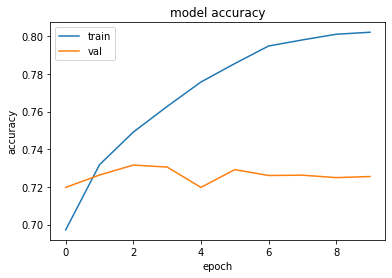

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

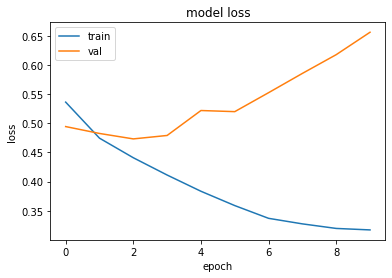

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
from keras.models import load_model
model = load_model(path + 'Test/weights_Textcnn_vreview_glove_sentece.hdf5')
# accr = model.evaluate(test1,label_test)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [16]:
from sklearn import metrics
acc = model.predict(test1)
accr = np.round(acc)
print(metrics.f1_score(label_test, accr))

0.7644318539502676
